In [2]:
""" imports """
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn

from collections import namedtuple

In [3]:
""" given ellipse function """

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [4]:
""" load data """
flowers : list[str] = []

def assignFlower(raw : bytes) -> int:
    """ converts bytes data to a string, then assigns each flower type an int """
    global flowers
    flower : str = raw.decode("utf-8")
    flowers += [flower] if flower not in flowers else []
    return flowers.index(flower)

data = np.loadtxt(open("iris.data", "rb"), delimiter=",", converters={4 : assignFlower})
X = data[:,:4]
y = data[:,4]

k = len(flowers)
X.shape

(150, 4)

In [5]:
""" Reduces the dimensionality of the dataset """

def svd(dataset : np.ndarray) -> np.ndarray:
    d = (dataset-dataset.mean(axis=0))  # /dataset.std()
    u, ls, vh = np.linalg.svd(d, full_matrices=True)

    s = np.zeros((u.shape[0],2))
    np.fill_diagonal(s, ls)

    dataset_svd1 = np.dot(u, s)
    dataset_svd = np.dot(d, vh[:2].T)
    return dataset_svd

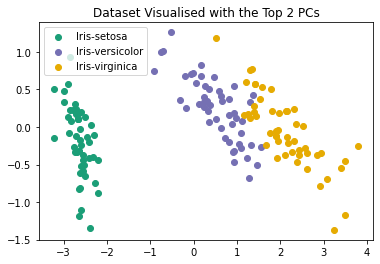

In [6]:
""" display data as 2D plot """
Z : np.ndarray = svd(X)

colourmap = plt.cm.Dark2
flowerColour = lambda f : colourmap(1. * f/k)

def displayZ(ax=None, colourFunction=flowerColour, grouping=None):
    grouping = y if grouping is None else grouping
    ax = ax if ax else plt.gca()
    for i in range(k):
        flowerIndexes = [int(j) for j, f in enumerate(grouping) if f==i]
        Zp = np.array([Z[j] for j in flowerIndexes]) 
        ax.scatter(Zp[:,0], Zp[:,1], color=colourFunction(i), label=f"{flowers[i]}")

displayZ()
plt.title("Dataset Visualised with the Top 2 PCs")
plt.legend(loc="upper left")
plt.show()

In [42]:
Cluster = namedtuple("Cluster", "pi mu s")

class Theta:
    def __init__(self, X : np.ndarray, k : int):
        self.X = X
        self.k = k
        
        self.theta = []
        self.kmeans = KMeans(k)
        self.assignment = self.kmeans.fit_predict(Z)

        self.theta.append([Cluster(1/3, mean, [[1,0],[0,1]]) for mean in self.kmeans.cluster_centers_])
        # initiate theta with data from k_means
    
    def calc_r(self, x, cluster: Cluster) -> float:
        theta = self.theta[-1]
        dist_c= mvn(mean=cluster.mu,
                    cov= cluster.s)
        t1 = dist_c.pdf(x)
        tPrior = cluster.pi
        top = t1 * tPrior

        botSeries = []
        for c_p in (i for i in range(k)):
            dist_cp = mvn(mean=theta[c_p].mu,
                          cov= theta[c_p].s)
            b1 = dist_cp.pdf(x)
            bPrior = theta[c_p].pi
            botSeries.append(b1 * bPrior)
        
        bot = sum(botSeries)
        
        return top/bot
    
    def assign(self, points, theta=None) -> np.array:
        theta = self.theta[-1] if theta is None else theta
        return np.array([np.argmax([self.calc_r(x, c) for c in theta]) for x in points])

    def __next__(self):
        r = np.array([[self.calc_r(self.X[i], self.theta[-1][c]) for c in range(self.k)] 
                      for i in range(len(self.X))])
        
        theta_n = []
        for c in range(self.k):
            rc = np.array([r_i[c] for r_i in r])
            sum_rc = sum(rc)
            pi = (1/len(r)) * sum_rc

            mu = (1/sum_rc) * sum((rc*self.X.T).T)

            s = np.matmul((rc*(self.X-mu).T), (self.X-mu))
            s = (1/sum_rc) * s

            theta_n += [Cluster(pi, mu, s)]
        self.theta += [theta_n]
        return theta_n

    def converge(self):
        converged : bool = len(self.theta) != 1
        while not converged:
            theta_o = self.theta[-1]
            theta_n = next(self)
            r = np.array([[self.calc_r(x, c) for c in theta_n] 
                      for x in self.X])
            newAssignment = np.argmax(r, axis=1)
            converged = all(self.assignment == newAssignment)
            self.assignment = newAssignment
            converged = len(self.theta) == 40
        return self.theta[-1]

theta = Theta(Z, k)

In [43]:
print("final theta:")
stringFormat = []
for c in theta.converge():
    pi = f"{c.pi :.4f}"
    mu = f"[{c.mu[0] :.4f}  {c.mu[1] :.4f}]"
    sigma = f"[[{c.s[0,0] :.4f}  {c.s[0,1] :.4f}]  [{c.s[1,0] :.4f}  {c.s[1,1] :.4f}]]"
    stringFormat.append((pi,mu,sigma))

maxlen = lambda i: len(max(stringFormat, key=lambda x: len(x[i]))[i])
for pi,mu,sigma in stringFormat:
    piOffset = maxlen(0)-len(pi)
    muOffset = maxlen(1)-len(mu)
    sgOffset = maxlen(2)-len(sigma)
    print(f"  {{pi_c={pi},{' '*piOffset} mu={mu},{' '*muOffset} sigma={sigma}}}")

final theta:
  {pi_c=0.2916, mu=[0.4791  0.2275],   sigma=[[0.3537  -0.2199]  [-0.2199  0.1916]]}
  {pi_c=0.3751, mu=[1.9744  -0.0075],  sigma=[[0.5966  -0.2963]  [-0.2963  0.2292]]}
  {pi_c=0.3333, mu=[-2.6408  -0.1905], sigma=[[0.0478  -0.0559]  [-0.0559  0.2147]]}


0 0.8866666666666667
1 0.8933333333333333
2 0.9
3 0.9133333333333333
4 0.92
5 0.9333333333333333
6 0.9466666666666667
7 0.9333333333333333
8 0.9466666666666667
9 0.9533333333333334
10 0.96
11 0.96
12 0.96
13 0.9533333333333334
14 0.9533333333333334
15 0.96
16 0.96
17 0.9733333333333334
18 0.9733333333333334
19 0.9733333333333334
20 0.98
21 0.98
22 0.98
23 0.98
24 0.98
25 0.98
26 0.98
27 0.9733333333333334
28 0.9733333333333334
29 0.9733333333333334
30 0.9733333333333334
31 0.9733333333333334
32 0.9733333333333334
33 0.9733333333333334
34 0.9733333333333334
35 0.9733333333333334
36 0.9733333333333334
37 0.9733333333333334
38 0.9733333333333334
39 0.9733333333333334
[ 0.12604036 -0.05341593]
[-0.32796573  0.11863265]
[0.05562375 0.02480839]
[-0.0104577   0.00685418]
[-0.00012324  0.00556691]
[-0.05560616 -0.02480327]
[-0.00197245 -0.00702523]
[0.00616642 0.00786386]
[-1.74050584e-05 -6.09953335e-06]
[-0.00429557 -0.00662064]
[0.00700372 0.00813861]
[-3.99009967e-08  2.16635977e-07]
[-0.0

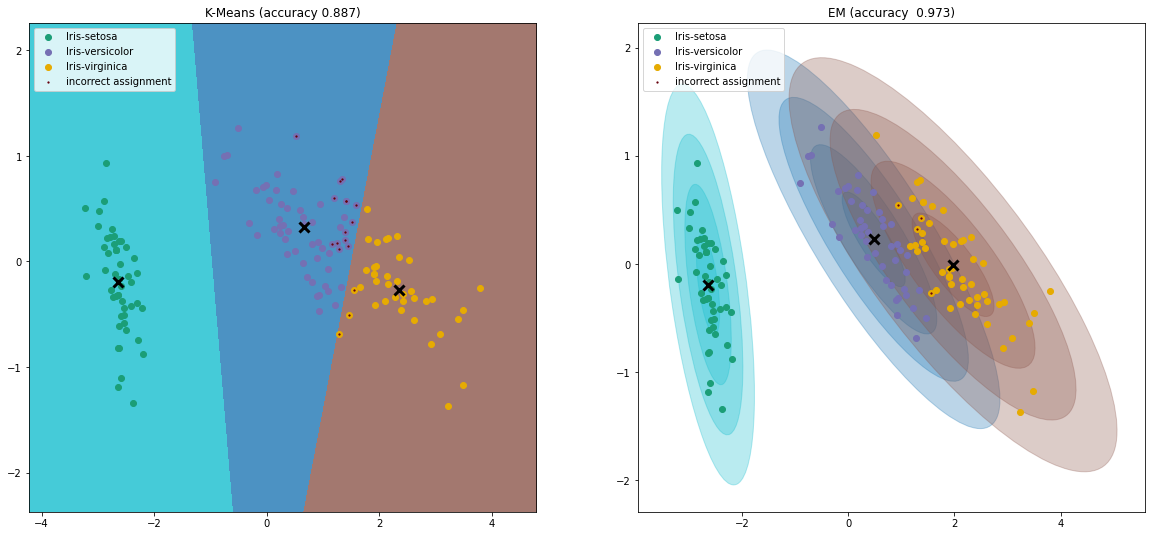

In [47]:
clusters = theta.converge()

clusterFlower : dict[int:int] = {i:-1 for i in range(k)}

for c in range(theta.k):
    flowerAssignment = [0, 0, 0]  # running count of how many of each flower is assigned to this cluster
    for a, groundTruth in zip(theta.assign(Z), y):  # counts how many of each flower is assigned to the given cluster
        flowerAssignment[int(groundTruth)] += 1 if a==c else 0
    clusterFlower[c] = np.argmax(flowerAssignment)  # the cluster is given the flower that has the most points assigned to it

fig, plots = plt.subplots(1, 2, figsize=(20,9))

clusterColourmap = plt.cm.tab10

for cluster, hue in zip(clusters, np.linspace(0.,1.,3)):
    draw_ellipse(cluster.mu, cluster.s, ax=plots[1], alpha=0.3, color=clusterColourmap(hue)) 

# create a point mesh that covers the axes
meshFidelity = 0.001
x_min, x_max = Z[:, 0].min() - 1, Z[:, 0].max() + 1
y_min, y_max = Z[:, 1].min() - 1, Z[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, meshFidelity), np.arange(y_min, y_max, meshFidelity))

# Label each point in the mesh with the kmeans model used to start off the EM algorithm.
boundary = theta.kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# plot the cluster areas
boundary = boundary.reshape(xx.shape)
plots[0].imshow(boundary,
                interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=clusterColourmap,
                aspect="auto",
                origin="lower",
                alpha=0.8)

kmeansAssignment = [clusterFlower[l] for l in theta.kmeans.labels_]
emAssignment = [clusterFlower[l] for l in theta.assign(Z)]

displayZ(plots[0], grouping=kmeansAssignment)
displayZ(plots[1], grouping=emAssignment)

centroidses = theta.kmeans.cluster_centers_, np.array([c.mu for c in theta.theta[-1]])
for plot, centroids in zip(plots, centroidses):
    plot.scatter(centroids[:, 0],
                 centroids[:, 1],
                 marker="x",
                 s=100,
                 linewidths=3,
                 color="black")

def plotIncorrectAssignments(assignment, ax):
    incorrectPoints = np.array([Z[i] for i,a in enumerate(assignment) if a != y[i]])
    ax.scatter(incorrectPoints[:,0], 
               incorrectPoints[:,1], 
               color=plt.cm.Reds(1.),
               marker="o",
               alpha=1,
               s=1.5,
               label="incorrect assignment")
    
    
plotIncorrectAssignments(emAssignment, plots[1])
plotIncorrectAssignments(kmeansAssignment, plots[0])

accuracy = lambda assignment : sum(assignment==y)/len(y)



plots[0].title.set_text(f"K-Means (accuracy {accuracy(kmeansAssignment) :.3f})")
plots[1].title.set_text(f"EM (accuracy {accuracy(emAssignment) : .3f})")

plots[0].legend(loc="upper left")
plots[1].legend(loc="upper left")

for i, t in enumerate(theta.theta):
    rawAssignment = theta.assign(Z, t)
    flowerAssignment = [clusterFlower[c] for c in rawAssignment]
    acc = accuracy(flowerAssignment)
    print(i, acc)

clusterPoints = [[c.mu for c in t] for t in theta.theta]
for i, t in enumerate(clusterPoints[:-1]):
    for j, mu in enumerate(t):
        print(clusterPoints[i+1][j] - mu)